# This notebook is intended to explore iMaterialist dataset and train an MRCNN model to detect and mask the clothing items. 
Maruf Ahmed - 2025

In [1]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
DATA_DIR = Path('/kaggle/input')
ROOT_DIR = Path('/kaggle/working')

NUM_CATS = 46
IMAGE_SIZE = 512

# Dowload Libraries and Pretrained Weights
We clone the Mask_RCNN library and pretained mask_rcnn_coco.h5 model as a base to finetune on our iMaterialist dataset.

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # preventing a git repository inside our own
!rm -rf images assets # we don't need

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [4]:
# we need to append Mask_RCNN as root directory so that we can find the modules properly
sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


Using TensorFlow backend.


In [5]:
# Now we get our pretrained model
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Jan 28 13:46 mask_rcnn_coco.h5


# Setup MRCNN Configuration
MRCNN has a lot of configurations. We are using only a few

In [6]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # ideal for a single NVIDIA P100
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# Prepare Datasets

In [8]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [9]:
segment_df = pd.read_csv(DATA_DIR/"train.csv")

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that have attributes: 3.47%


Segments that contain attributes are only 3.46% of data, and [according to the host](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/discussion/90643#523135), 80% of images have no attribute. So, in the first step, we can only deal with categories to reduce the complexity of the task.

In [10]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


ImageId    ...     CategoryId
0  00000663ed1ff0c4e0132b9b9ac53f6e.jpg    ...              6
1  00000663ed1ff0c4e0132b9b9ac53f6e.jpg    ...              0
2  00000663ed1ff0c4e0132b9b9ac53f6e.jpg    ...             28
3  00000663ed1ff0c4e0132b9b9ac53f6e.jpg    ...             31
4  00000663ed1ff0c4e0132b9b9ac53f6e.jpg    ...             32

[5 rows x 6 columns]

Rows with the same image are grouped together

In [11]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45195


EncodedPixels  ...  Width
ImageId                                                                                  ...       
00000663ed1ff0c4e0132b9b9ac53f6e.jpg  [6068157 7 6073371 20 6078584 34 6083797 48 60...  ...   3676
0000fe7c9191fba733c8a69cfaf962b7.jpg  [2201176 1 2203623 3 2206071 5 2208518 8 22109...  ...   2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg  [2673735 2 2676734 8 2679734 13 2682733 19 268...  ...   1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg  [435 132 1002 132 1569 132 2136 132 2703 132 3...  ...    400
0004467156e47b0eb6de4aa6479cbd15.jpg  [132663 8 133396 25 134130 41 134868 53 135611...  ...    500

[5 rows x 4 columns]

This is our clean data frame where we have imageId, EncodedPixels, the categories it contains, height and width. 

### **How Masking Works**
1. **Decoding the RLE**:
   - The RLE data is converted into a 1D array of binary values (0s and 1s) of size equal to the total number of pixels in the image (height × width).
   - The "start pixel" and "run length" define which parts of this array should be filled with 1s.

   Example:
   ```
   EncodedPixels: "3 5 12 4"
   Image size: 5x5 (25 pixels)
   ```
   Decoding steps:
   - Start at position 3 → Fill 5 pixels with 1s.
   - Jump to position 12 → Fill 4 pixels with 1s.
   Resulting 1D mask:
   ```
   [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   ```

2. **Reshaping to 2D**:
   - The 1D binary mask is reshaped into a 2D array based on the image dimensions (height × width).

3. **Resizing (if necessary)**:
   - The mask is resized to a fixed size (e.g., `IMAGE_SIZE x IMAGE_SIZE`) using interpolation, typically with `cv2.resize` and `INTER_NEAREST` to preserve discrete binary values.

---

### **Usage in iMaterialist Dataset**
- Each image may have multiple RLE-encoded masks corresponding to different regions or categories.
- During preprocessing:
  - Decode the RLE for each mask into a binary matrix.
  - Stack these binary masks along a new axis to create a 3D tensor of shape `(height, width, num_masks)`.
- The masks are often used as input for training segmentation models, where each pixel is classified as belonging to one of the categories.

This setup allows the dataset to efficiently store complex segmentation information while enabling accurate mask reconstruction for tasks like semantic segmentation.

In [14]:
# convert to RGB and resize to a square
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

The crucial part is to create a dataset for this task. This FashionDataset class is a custom dataset for handling labeled fashion images. It initializes with a DataFrame containing image metadata, adds image and label information, and provides methods to load resized images (load_image) and generate segmentation masks (load_mask) for the images based on their pixel annotations, ensuring compatibility with the target model's requirements

In [12]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

## Now we can visualize some images from the dataset and their corresponding masks

('/kaggle/input/train/ddf54f3ff81977dc93a6f6f0dd40f5c7.jpg', ['hat', 'epaulette', 'epaulette', 'pocket', 'pants', 'pants', 'pants', 'top, t-shirt, sweatshirt', 'zipper', 'lapel', 'jacket', 'sleeve', 'zipper', 'belt', 'shoe'])


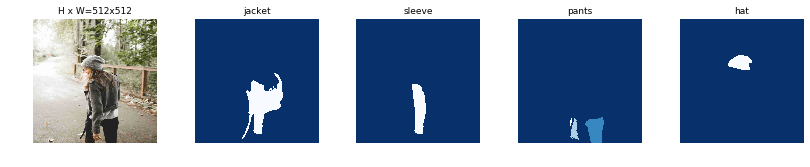

('/kaggle/input/train/0b7076ea4c14884e1dfbfab31f41bc97.jpg', ['dress', 'neckline', 'bag, wallet', 'shoe', 'shoe'])


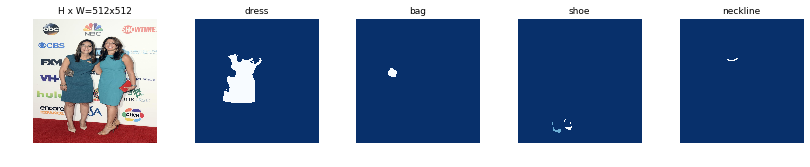

('/kaggle/input/train/059cc2a531ce5727a3318abfdbecee44.jpg', ['headband, head covering, hair accessory', 'neckline', 'dress', 'bead', 'watch'])


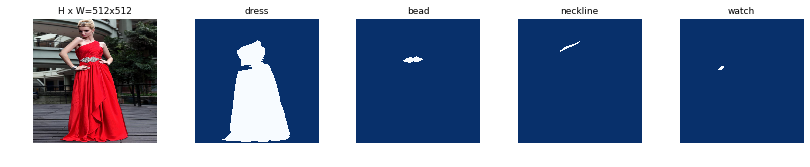

('/kaggle/input/train/7d8e955a0af213b57a25c47da839cf06.jpg', ['dress', 'neckline', 'sleeve', 'sleeve', 'hat'])


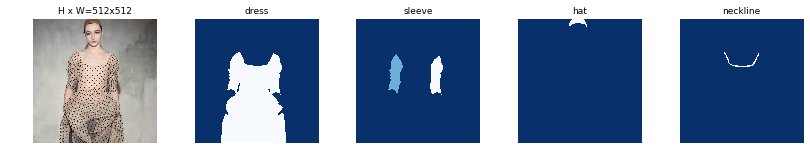

('/kaggle/input/train/ea1022f21f09e2f9a767dcfa64317fe5.jpg', ['shoe', 'shoe', 'pants', 'top, t-shirt, sweatshirt', 'sleeve', 'sleeve', 'glasses', 'bag, wallet'])


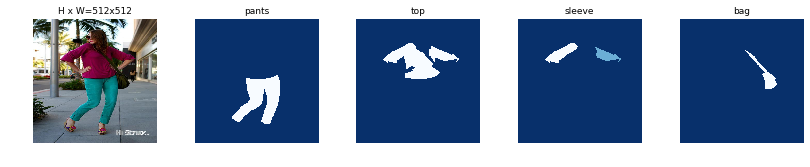

('/kaggle/input/train/682424d9a0b4f5fc917b9483abeba9ab.jpg', ['neckline', 'jumpsuit', 'hat', 'shoe', 'shoe'])


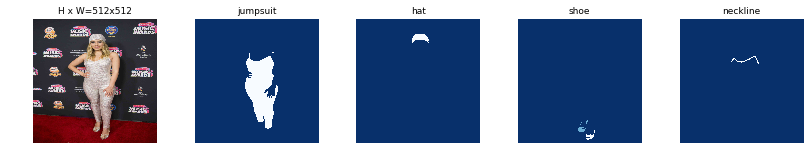

In [15]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

## Now, we will partition the data into train and validation sets

In [16]:
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df)

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

Let's visualize class distributions of the train and validation data.

Total training images: 36156
Total training segments (annotations): 264949


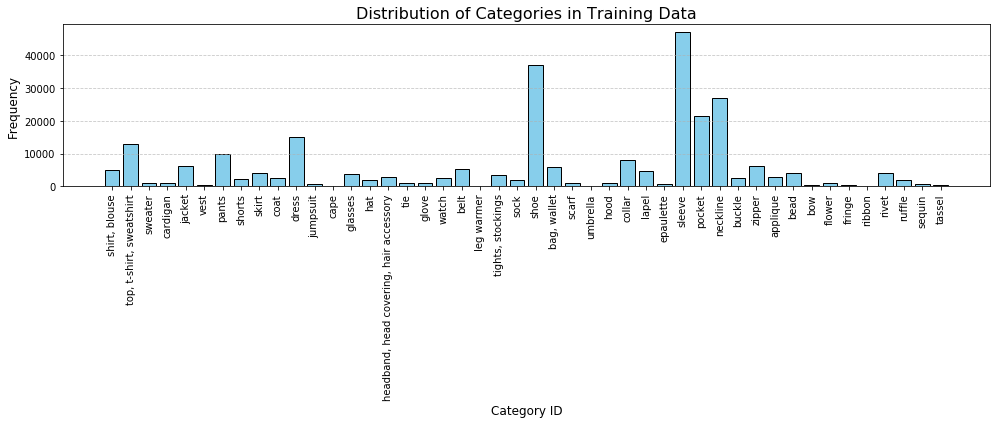

Total validation images: 9039
Total validation segments (annotations): 66264


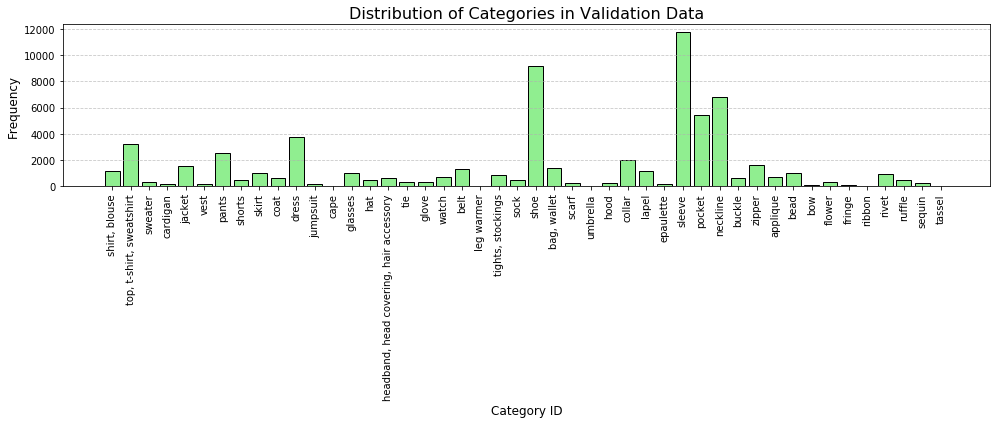

In [29]:
# Analyze the distribution of segments in the training dataset
train_segments = np.concatenate(train_df['CategoryId'].values).astype(int)
total_train_images = len(train_df)
total_train_segments = len(train_segments)
print(f"Total training images: {total_train_images}")
print(f"Total training segments (annotations): {total_train_segments}")

# Plot the segment distribution for training data
plt.figure(figsize=(14, 6))  # Increased height for better visibility
values, counts = np.unique(train_segments, return_counts=True)
plt.bar(values, counts, color='skyblue', edgecolor='black')
plt.title("Distribution of Categories in Training Data", fontsize=16)
plt.xlabel("Category ID", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(values, label_names, rotation='vertical', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensure labels fit within the frame
plt.gca().set_facecolor('#FFFFFF')  # Set background color 
plt.gcf().set_facecolor('#FFFFFF')  # Set figure background color
plt.show()

# Analyze the distribution of segments in the validation dataset
valid_segments = np.concatenate(valid_df['CategoryId'].values).astype(int)
total_valid_images = len(valid_df)
total_valid_segments = len(valid_segments)
print(f"Total validation images: {total_valid_images}")
print(f"Total validation segments (annotations): {total_valid_segments}")

# Plot the segment distribution for validation data
plt.figure(figsize=(14, 6))  # Increased height for better visibility
values, counts = np.unique(valid_segments, return_counts=True)
plt.bar(values, counts, color='lightgreen', edgecolor='black')
plt.title("Distribution of Categories in Validation Data", fontsize=16)
plt.xlabel("Category ID", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(values, label_names, rotation='vertical', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ensure labels fit within the frame
plt.gca().set_facecolor('#FFFFFF')  # Set background color
plt.gcf().set_facecolor('#FFFFFF')  # Set figure background color
plt.show()


# Training

In [31]:
LR = 1e-4 # Starting with low learning rate
EPOCHS = [2, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

This section creates a Mask R-CNN model and loads pretrained coco model weights

In [32]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # horizontal flip for augmentation
])

First, let's train only the head nodes of the model to see the performance

In [34]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2,
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /kaggle/working/fashion20250128T1417/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

let's take a brief moment to explore the outputs:
These layers are the head of Mask R-CNN architecture.

### Layers Overview:
1. **FPN (Feature Pyramid Network) Layers**:
   - These layers are designed to generate feature maps at multiple scales to improve the detection of objects at different sizes.
   - `fpn_c5p5`, `fpn_c4p4`, `fpn_c3p3`, `fpn_c2p2`: Convolutional layers that process the feature maps at different pyramid levels (from coarser to finer resolution).
   - `fpn_p5`, `fpn_p2`, `fpn_p3`, `fpn_p4`: Feature pyramid outputs that provide multi-scale predictions.

2. **RPN (Region Proposal Network) Layers**:
   - `rpn_conv_shared`: Shared convolutional layer that processes the input feature map to generate region proposals.
   - `rpn_class_raw`: Produces the classification scores for each region proposal (whether it's an object or background).
   - `rpn_bbox_pred`: Predicts bounding box offsets for each region proposal.

3. **Mask R-CNN Layers**:
   - These layers are responsible for generating the final object masks and class predictions.
   - `mrcnn_mask_*`: These are convolutional layers followed by batch normalization layers that predict the segmentation mask for each region proposal.
   - `mrcnn_class_*`: These layers predict the object class for each region proposal.
   - `mrcnn_bbox_fc`: Fully connected layer for bounding box prediction.
   - `mrcnn_mask_deconv`: Deconvolution layer used to upsample the mask predictions.
   - `mrcnn_class_logits`: Final logits layer for object classification.
   - `mrcnn_mask`: The final output layer containing the predicted masks.

### Losses in the Training Process:
The losses are metrics used to guide the optimization process during training. Each loss represents a different aspect of the model's performance, and they are weighted during training. Here’s a breakdown of the losses:

- **rpn_class_loss**: The loss for classifying region proposals (whether they are objects or background).
- **rpn_bbox_loss**: The loss for refining the bounding box predictions of the region proposals. It typically uses a smooth L1 loss.
- **mrcnn_class_loss**: The loss for classifying the object categories (e.g., person, car) for each region proposal.
- **mrcnn_bbox_loss**: The loss for refining the bounding box predictions for the detected objects.
- **mrcnn_mask_loss**: The loss for predicting the binary masks for each detected object. This is typically a binary cross-entropy loss.

The overall **total loss** (e.g., `loss: 3.0576`) is a weighted sum of these individual losses. The goal during training is to minimize this total loss by adjusting the model's parameters.

# Then, we train all layers

In [39]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 2. LR=0.0001

Checkpoint Path: /kaggle/working/fashion20250128T1417/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b     

Afterwards, we increase the LR and train again.

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2,
            epochs=EPOCHS[0],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

Let's visualize training history and choose the best epoch.

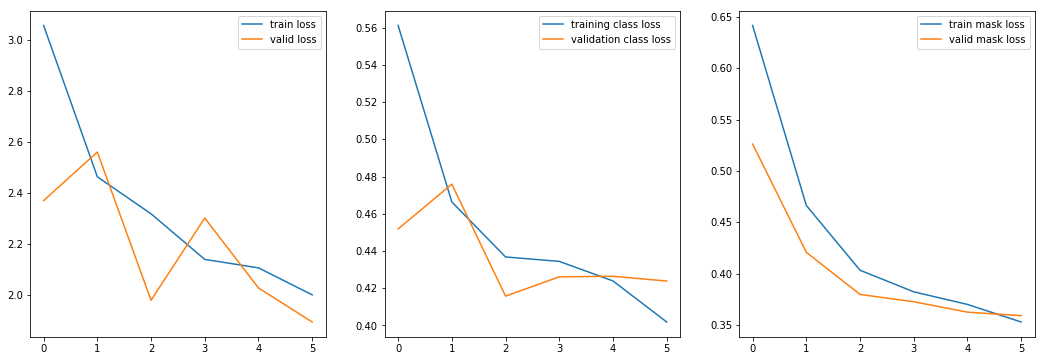

In [42]:
epochs = range(EPOCHS[1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="training class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="validation class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()
plt.gca().set_facecolor('#FFFFFF')  # Set background color 
plt.gcf().set_facecolor('#FFFFFF')  # Set figure background color

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

# Prediction

The final step is to use our model to predict test data.

In [43]:
# glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
# model_path = glob_list[0] if glob_list else ''
model_path = "/kaggle/working/fashion20250128T1417/mask_rcnn_fashion_0006.h5"

This cell defines InferenceConfig and loads the best trained model.

In [44]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/working/fashion20250128T1417/mask_rcnn_fashion_0006.h5
Re-starting from epoch 6


Then, load the submission data.

In [45]:
sample_df = pd.read_csv(DATA_DIR/"sample_submission.csv")
sample_df.head()

ImageId EncodedPixels  ClassId
0  003d41dd20f271d27219fe7ee6de727d.jpg           1 1       23
1  0046f98599f05fd7233973e430d6d04d.jpg           1 1       23
2  004e9e21cd1aca568a8ffc77a54638ce.jpg           1 1       23
3  005b37fce3c0f641d327d95dd832f51b.jpg           1 1       23
4  0094940c58c343b742f48ae26eb5e9fa.jpg           1 1       23

Here is the main prediction steps, along with some helper functions.

In [46]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [47]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [49]:
%%time
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str(DATA_DIR/'test'/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

  3%|▎         | 92/3200 [00:34<15:16,  3.39it/s] 

KeyboardInterrupt: 

Make all predictions

In [50]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()

Total image results:  92
Missing Images:  1


ImageId   ...   ClassId
0  003d41dd20f271d27219fe7ee6de727d.jpg   ...        31
1  003d41dd20f271d27219fe7ee6de727d.jpg   ...        31
2  003d41dd20f271d27219fe7ee6de727d.jpg   ...        23
3  003d41dd20f271d27219fe7ee6de727d.jpg   ...        10
4  003d41dd20f271d27219fe7ee6de727d.jpg   ...        33

[5 rows x 3 columns]

In [51]:
submission_df.to_csv("submission.csv", index=False)

Finally, we can visualize the detections made by our model

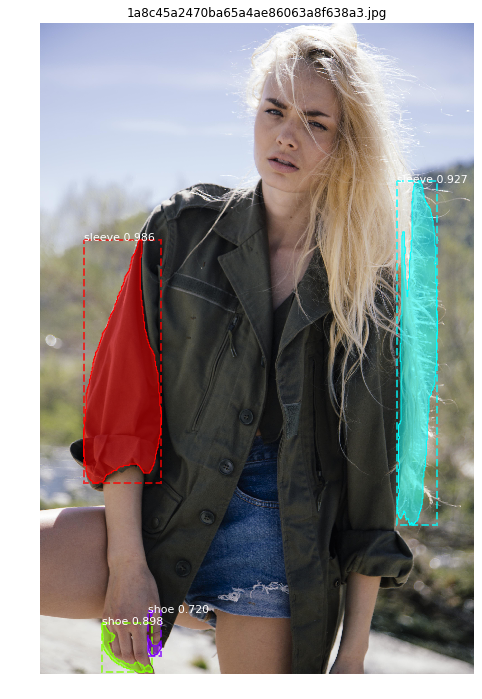

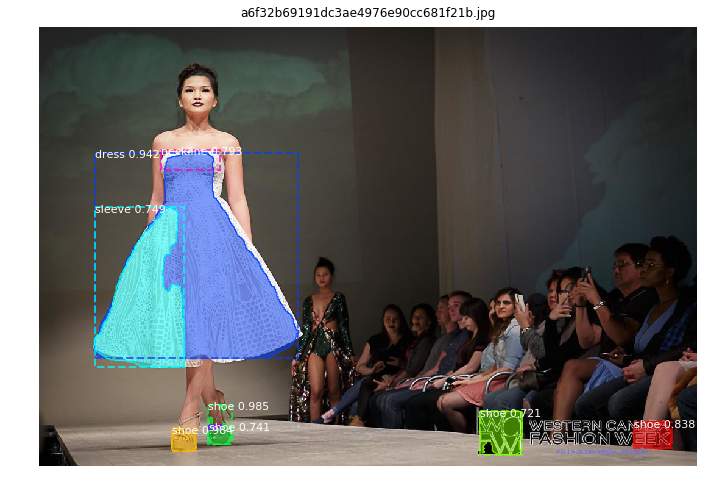

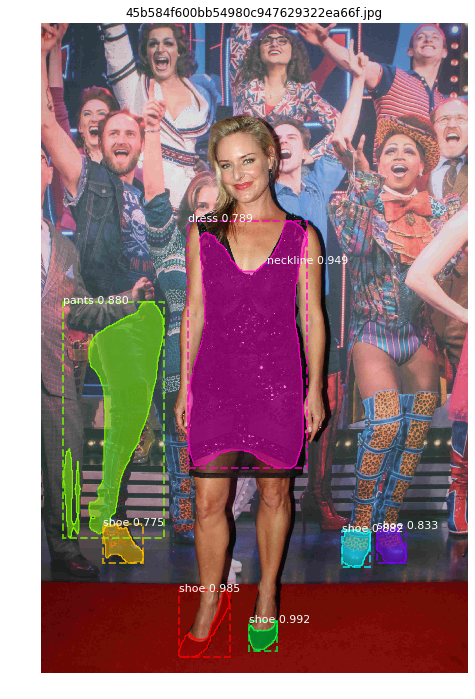

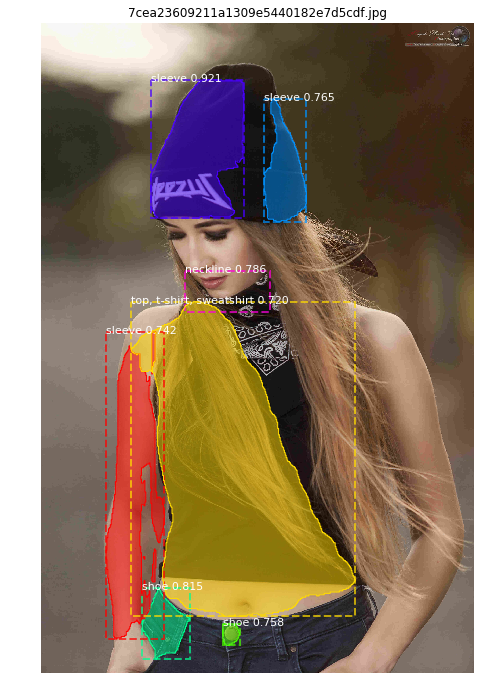

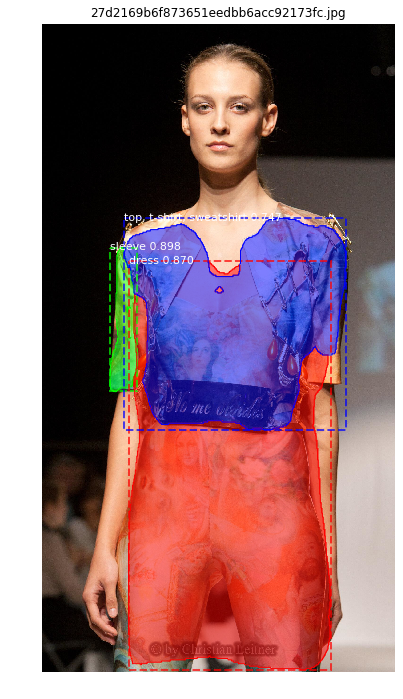

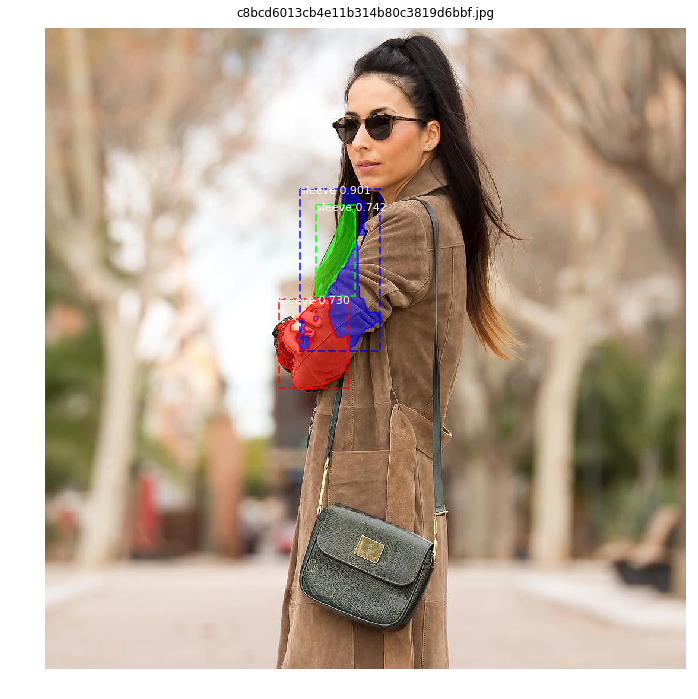

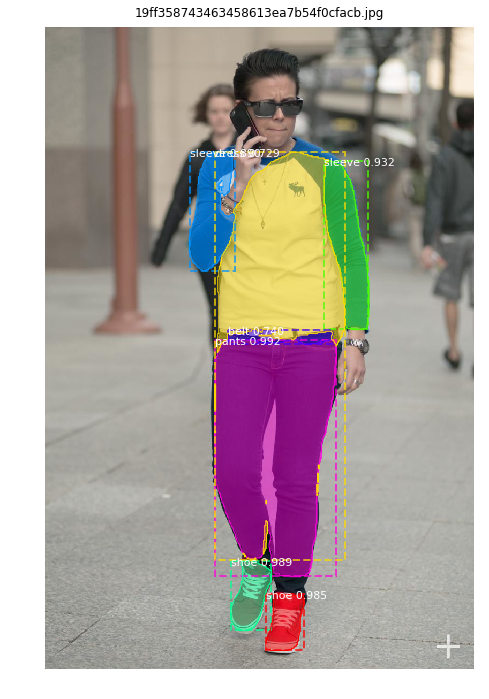

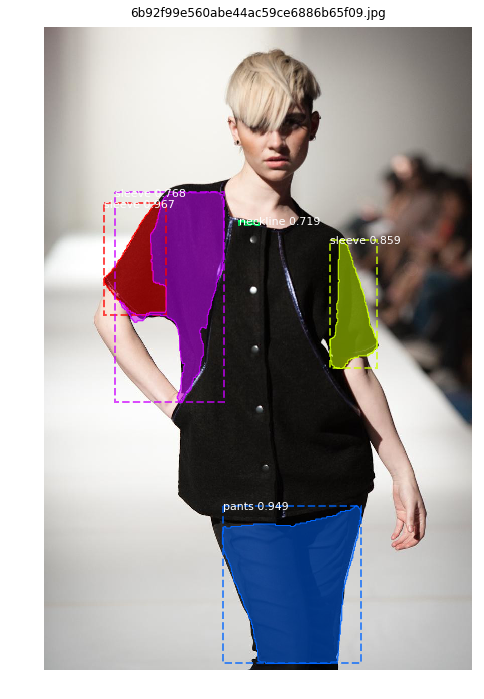

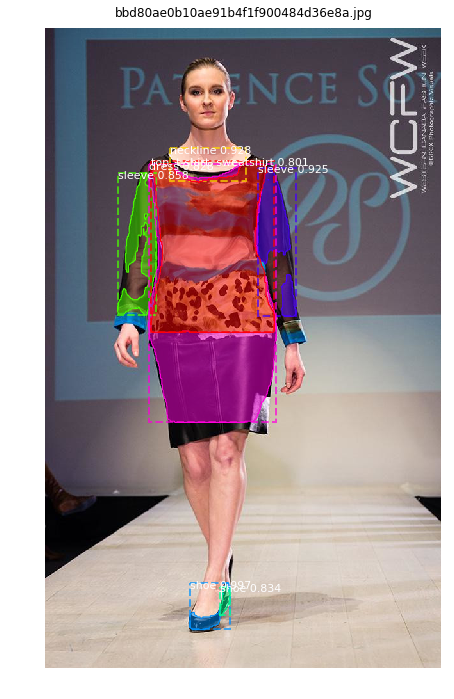

In [52]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

Credits: The starter notebook by kaggle/com/pednoi helped a lot during this process.